In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os
from functools import reduce

from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
from evaluation import *

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def create_ap_df(ingredients, ap_list, column='tfidf_ap'):
    df = pd.DataFrame.from_dict(dict(zip(ingredients, ap_list)).items())
    df.columns = ['ingredient', column]
    return df

In [3]:
# Set input file directory
ip_file_dir = "/Users/chahaksethi/Desktop/Target/target/target_recipe_project/data/"
# Get grocery product hierarchy information
group4 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products_group4.csv'))

# Merge scraped information into the hierarchy table
group4 = pd.merge(group4, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group4 = preprocess_df(group4)

In [4]:
group4['title_lower'] = group4['title'].str.lower()

In [ ]:
pan_docs[pan_docs['tcin'].isin([76190391, 81801118, 83776543, 83344279, 83344271, 83776447, 76823950, 76181945, 76739081, 83344254])]


In [7]:
# Find relevant pan products
pan_docs = group4[((group4['sub_group_name'] == 'KITCHEN')  
                   & (group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets'])))]

# Find relevant saucepan products
saucepan_docs = group4[((group4['sub_group_name'] == 'KITCHEN') 
                   & (group4['subclass_name'] == 'SAUCEPAN') 
                   & (group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets'])))]

# Find relevant skillet products
skillet_docs = group4[((group4['sub_group_name'] == 'KITCHEN')
                   & ((group4['title_lower'].str.contains('skillet'))
                   & (group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets'])))
                   | ((group4['class_name'] == 'SMALL APPLIANCES') & (group4['item_type_name'] == 'Electric Skillets')))]

# Find relevant Pot products
pot_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
                & ((group4['subclass_name'].isin(['STOCK POT','STOCKPOT']))
                   |((group4['item_type_name'].isin(['Pots and Pans', 'Cookware Sets']))
                    & (group4['title_lower'].str.contains('stock pot'))))]

# Find relevant bowl products
bowl_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'SERVING BOWL')) 
                    |((group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Mixing Bowls'))
                    |((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'MIXING BOWLS')) ]

# Find relevant colander products
colander_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'COLANDER')) 
                      |((group4['sub_group_name'] == 'KITCHEN')
                    & (group4['item_type_name'].isin(['Colanders','Strainers'])))]

# Find relevant whisk products
whisk_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] == 'WHISK')) 
                   |((group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name']=='Whisks'))]

# Find relevant griddle products
griddle_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
                     & ((group4['subclass_name'] == 'GRIDDLE') 
                       |(group4['item_type_name']=='Grill Pans and Griddles')
                       |((group4['class_name'] == 'SMALL APPLIANCES') & (group4['item_type_name'] == 'Electric Griddles' )))]

                  
# Find relevant Wok products
wok_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
                & ((group4['subclass_name'].isin(['WOK PAN','WOKPAN']))
                 |((group4['class_name'] == 'SMALL APPLIANCES') & (group4['item_type_name'] == 'Electric Woks')))] 

# Find relevant KNIFE products
knife_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['title_lower'].str.contains('knife'))] 
                   
# Find relevant graters
grate_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Graters')] 

# Find relevant mortar & pestle
mrtrpestle_docs = group4[(group4['sub_group_name'] == 'KITCHEN')
                         & (group4['item_type_name'] == 'Mortars and Pestles')] 

# Find relevant Blender products
blender_docs = group4[((group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'].isin(['BLENDER','HAND BLENDER']))) 
                      |((group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name']=='Blenders'))]

# Find relevant basting brushes
brush_docs = group4[(group4['sub_group_name'] == 'KITCHEN') 
            & (group4['item_type_name'].isin(['Basting Brushes','Vegetable Brushes']))] 

# Find relevant Spatula products
spatula_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['subclass_name'] =='SPATULA')] 

# Find relevant sPOON products
spoon_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] =='Kitchen Spoons')] 

# Find relevant Cup products
cup_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Measuring Cups')] 

# Find relevant Sheets products
sheet_docs = group4[((group4['class_name'] == 'BAKEWARE') & (group4['product_subtype_name'] == 'COOKWARE AND BAKEWARE')
            & (group4['item_type_name']== 'Bakeware Sets')) 
            | ((group4['class_name'] == 'FOOD STORAGE') & (group4['item_type_name']=='Food Wraps'))]


# Find relevant dish products
dish_docs = group4[(group4['sub_group_name'] == 'KITCHEN') & (group4['item_type_name'] == 'Baking Dishes')] 
                    
# Get product list from docs
pan_relevant_docs = list(pan_docs['tcin'].values)
bowl_relevant_docs = list(bowl_docs['tcin'].values)
colander_relevant_docs = list(colander_docs['tcin'].values)
whisk_relevant_docs = list(whisk_docs['tcin'].values)
griddle_relevant_docs = list(griddle_docs['tcin'].values)
skillet_relevant_docs = list(skillet_docs['tcin'].values)
wok_relevant_docs = list(wok_docs['tcin'].values)
knife_relevant_docs = list(knife_docs['tcin'].values)
grate_relevant_docs = list(grate_docs['tcin'].values)
mortar_pestle_relevant_docs = list(mrtrpestle_docs['tcin'].values)
blender_relevant_docs = list(blender_docs['tcin'].values)
brush_relevant_docs = list(brush_docs['tcin'].values)
spatula_relevant_docs = list(spatula_docs['tcin'].values)
spoon_relevant_docs = list(spoon_docs['tcin'].values)
cup_relevant_docs = list(cup_docs['tcin'].values)
saucepan_relevant_docs = list(saucepan_docs['tcin'].values)
sheet_relevant_docs = list(sheet_docs['tcin'].values)
dish_relevant_docs = list(dish_docs['tcin'].values)
pot_relevant_docs = list(pot_docs['tcin'].values)

# Create ingredient and relevant products mapping
ingredient_docs_map = {}
ingredient_docs_map = dict.fromkeys(['pan'], pan_relevant_docs)
ingredient_docs_map.update(dict.fromkeys(['bowl'], bowl_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['colander'], colander_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['whisk'], whisk_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['griddle'], griddle_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['skillet'], skillet_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['wok'], wok_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['knife'], knife_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['grate'], grate_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['mortar & pestle'], mortar_pestle_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['blender'], blender_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['brush'], brush_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['spatula'], spatula_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['spoon'], spoon_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['cup'], cup_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['saucepan'], saucepan_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['sheet', 'baking sheet'], sheet_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['dish', 'baking dish'], dish_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['pot','stock pot'], pot_relevant_docs))                                        

In [8]:
import pickle
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

In [9]:
# Get rankings for multiple ingredients
ingredients = ingredient_docs_map.keys()
relevant_docs_list = ingredient_docs_map.values()
k=20

In [10]:
# Get embeddings for Sentence Transformers 
lm_embedder = SentenceTransformer('all-MiniLM-L6-v2')
glove_embedder = SentenceTransformer('average_word_embeddings_glove.6B.300d')
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
mpnet_embedder = SentenceTransformer('all-mpnet-base-v2')
roberta_embedder = SentenceTransformer('all-distilroberta-v1')
# custom_embedder = SentenceTransformer('models/nli')

all_matches = group4['title_lower'].values

In [11]:
glove_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/glove_embeddings_products4.pkl')
lm_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/lm_embeddings_products4.pkl')
multi_lm_embeddings = get_embeddings('../../data/embeddings/hier_embeddings_products4.pkl')
mpnet_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/mpnet_embeddings_products4.pkl')
roberta_embeddings = get_embeddings('/Users/chahaksethi/Desktop/Target/data/embeddings/roberta_embeddings_products4.pkl')

In [12]:
pm = Mapper(group4)
clf_name_item_type_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-item_type_name'
clf_name_subclass_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-subclass_name'
clf_name_class_name = '/Users/chahaksethi/Desktop/Target/models/nli-classification-class_name'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [13]:
embedding_loc = '../../data/embeddings/hier_embeddings_products4.pkl'
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
# Bi encoder 
lm = TransformerRanker(model=lm_embedder, product_ids=group4['tcin'], max_rank=k)
lm.load_embeddings(lm_embeddings)

glove = TransformerRanker(model=glove_embedder, product_ids=group4['tcin'], max_rank=k)
glove.load_embeddings(glove_embeddings)

multi_lm = TransformerRanker(model=multi_lm_embedder, product_ids=group4['tcin'], max_rank=k)
multi_lm.load_embeddings(multi_lm_embeddings)

mpnet = TransformerRanker(model=mpnet_embedder, product_ids=group4['tcin'], max_rank=k)
mpnet.load_embeddings(mpnet_embeddings)

roberta = TransformerRanker(model=roberta_embedder, product_ids=group4['tcin'], max_rank=k)
roberta.load_embeddings(roberta_embeddings)

# Bi encoder with classifier
bi_encoder = SentenceTransformer(bi_encoder_name)
l1_ranker = TransformerRanker(model=bi_encoder, 
                              product_ids=group4['tcin'], 
                              max_rank=k,
                              clf=[clf_class_name,
                                   clf_item_type_name,
                                   clf_subclass_name])
l1_ranker.load_embeddings(multi_lm_embeddings)


cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)
cr_multi_lm = CrossEncoderRanker(bi_model=multi_lm, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                        cross_rank=k,
                        bi_rank=30)
# Cross encoder with classifier

l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                                cross_rank=k,
                                bi_rank=30,
                              mapper=pm,
                        weights=True)

In [14]:
# FastText
from ranker import FastRanker
from fse import Vectors
group4['description'] = np.where(pd.isnull(group4['description']), '', 
                                  group4['description'])
documents = list(group4['title'].str.cat(group4[['description'
                                                        ]], 
                                             sep= ' ').values)
embeddings = Vectors.from_pretrained("paranmt-300")
fr = FastRanker(embeddings, group4, max_rank=k)
fr.fit(documents)

In [15]:
glove_ranker_lists = glove.rank_products_recipe(ingredients)
lm_ranker_lists = lm.rank_products_recipe(ingredients)
multi_lm_ranker_lists = multi_lm.rank_products_recipe(ingredients)
mpnet_ranker_lists = mpnet.rank_products_recipe(ingredients)
roberta_ranker_lists = roberta.rank_products_recipe(ingredients)
fr_ranker_lists = fr.rank_products_recipe(ingredients)

multi_lm_clf_ranker_lists = l1_ranker.rank_products_recipe(ingredients)

Filtered pan for class_name: BTC CART
Filtered pan for item_type_name: Indoor Trash Cans
Filtered colander for class_name: FASHION OFFICE
Filtered whisk for class_name: FASHION OFFICE
Filtered wok for item_type_name: Indoor Trash Cans
Filtered grate for class_name: FASHION OFFICE
Filtered blender for class_name: GRILLS
Filtered spatula for class_name: FASHION OFFICE
Filtered spatula for item_type_name: Manual Sharpeners
Filtered saucepan for class_name: BTC CART
Filtered saucepan for item_type_name: Indoor Trash Cans
Filtered baking sheet sheet for class_name: ASTV
Filtered pot for item_type_name: Indoor Trash Cans
Filtered stock pot stock for class_name: BTC CART
Filtered stock pot stock for item_type_name: Indoor Trash Cans


In [16]:
cr_multi_lm_ranker_lists = cr_multi_lm.rank_products_recipe(ingredients)
cr_multi_lm_clf_ranker_lists = l2_ranker.rank_products_recipe(ingredients)

Filtered pan for class_name: BTC CART
Filtered pan for item_type_name: Indoor Trash Cans
Filtered colander for class_name: FASHION OFFICE
Filtered whisk for class_name: FASHION OFFICE
Filtered wok for item_type_name: Indoor Trash Cans
Filtered grate for class_name: FASHION OFFICE
Filtered blender for class_name: GRILLS
Filtered spatula for class_name: FASHION OFFICE
Filtered spatula for item_type_name: Manual Sharpeners
Filtered saucepan for class_name: BTC CART
Filtered saucepan for item_type_name: Indoor Trash Cans
Filtered baking sheet sheet for class_name: ASTV
Filtered pot for item_type_name: Indoor Trash Cans
Filtered stock pot stock for class_name: BTC CART
Filtered stock pot stock for item_type_name: Indoor Trash Cans


In [17]:
print('Fast Sentence Embeddings:')
# FastText rankings
fr_map, fr_ap = mean_average_precision(fr_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'FR MAP: {fr_map:.2f}')

print('\nSentence Transformers (L1 Ranker):')
# Glove rankings
glove_map, glove_ap = mean_average_precision(glove_ranker_lists, 
                                             relevant_docs_list, 
                                             return_ap = True)
print(f'Glove MAP: {glove_map: .2f}')

# LM rankings
lm_map, lm_ap = mean_average_precision(lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'LM MAP: {lm_map:.2f}')

# MPNET rankings
mpnet_map, mpnet_ap = mean_average_precision(mpnet_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'MPNET MAP: {mpnet_map:.2f}')

# Roberta rankings
roberta_map, roberta_ap = mean_average_precision(roberta_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Roberta MAP: {roberta_map:.2f}')

# Multi LM rankings
multi_lm_map, multi_lm_ap = mean_average_precision(multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM MAP: {multi_lm_map:.2f}')

# Multi LM CLF rankings
multi_lm_clf_map, multi_lm_clf_ap = mean_average_precision(multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM CLF MAP: {multi_lm_clf_map:.2f}')


print('\nSentence Transformers (L2 Ranker):')
# CR Multi LM rankings
cr_multi_lm_map, cr_multi_lm_ap = mean_average_precision(cr_multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM  MAP: {cr_multi_lm_map:.2f}')

# CR Multi LM CLF rankings
cr_multi_lm_clf_map, cr_multi_lm_clf_ap = mean_average_precision(cr_multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM CLF MAP: {cr_multi_lm_clf_map:.2f}')

Fast Sentence Embeddings:
FR MAP: 0.61

Sentence Transformers (L1 Ranker):
Glove MAP:  0.81
LM MAP: 0.80
MPNET MAP: 0.81
Roberta MAP: 0.84
Multi LM MAP: 0.91
Multi LM CLF MAP: 0.91

Sentence Transformers (L2 Ranker):
CR Multi LM  MAP: 0.93
CR Multi LM CLF MAP: 0.93


In [18]:
# Compare APs at ingredient level
dfs = [create_ap_df(ingredients, multi_lm_ap, 'multi_lm_ap'),
       create_ap_df(ingredients, roberta_ap, 'roberta_ap'),
       create_ap_df(ingredients, cr_multi_lm_ap, 'cr_multi_lm_ap')
      ]
df_final = reduce(lambda left, right: pd.merge(left, right, on='ingredient'), dfs)

pd.options.display.float_format = '{:,.1f}'.format
df_final

,ingredient,multi_lm_ap,roberta_ap,cr_multi_lm_ap
0,pan,1.0,1.0,1.0
1,bowl,1.0,0.8,1.0
2,colander,1.0,1.0,1.0
3,whisk,1.0,1.0,1.0
4,griddle,1.0,1.0,1.0
5,skillet,1.0,0.9,1.0
6,wok,0.9,0.9,0.8
7,knife,1.0,1.0,1.0
8,grate,1.0,1.0,0.9
9,mortar & pestle,1.0,1.0,1.0


boiler
[84095732, 79992496, 79992492, 79992490, 82213254, 82213252, 82826428, 82826419, 79707527, 82797952]


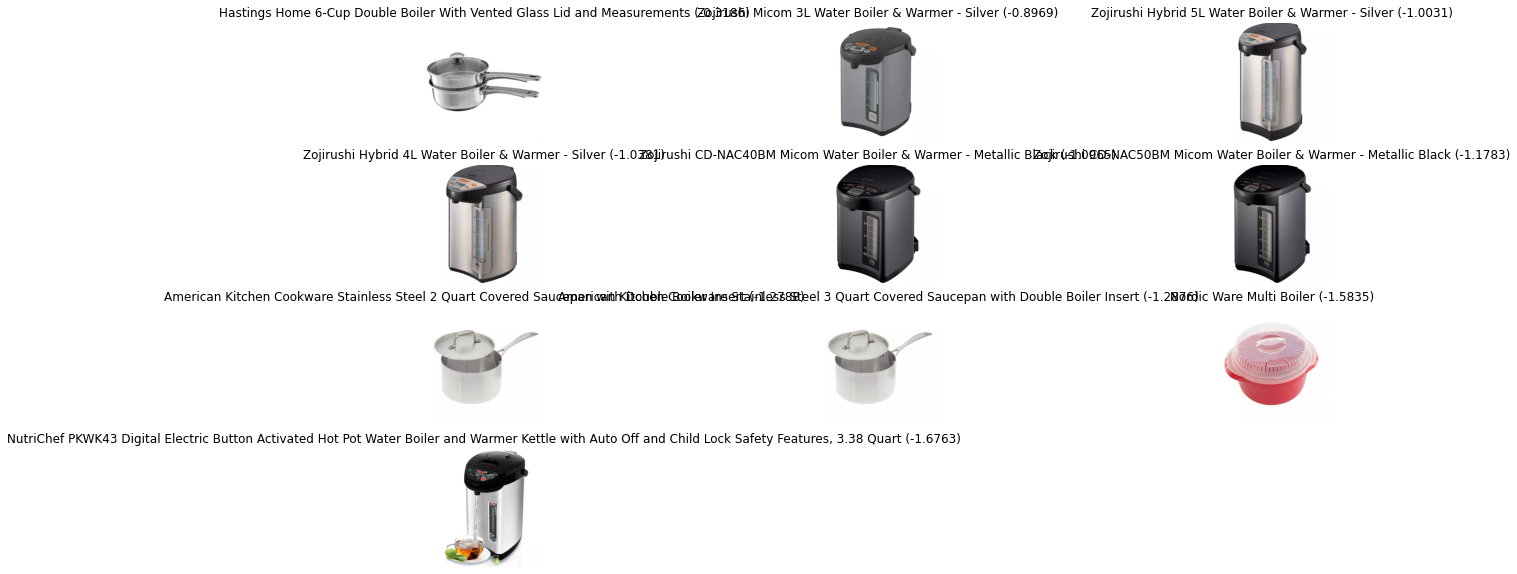

In [30]:
dp = DisplayProducts(ranker=cr_multi_lm, mapper=pm)
dp.display_products_ingredient('boiler', 10)

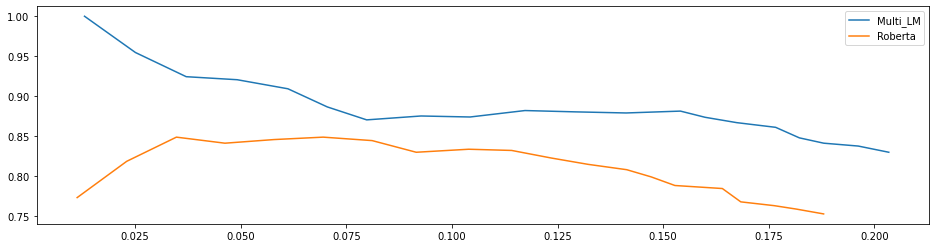

In [175]:
# Precision-Recall Plot for multiple ingredients
lm_avg_precision_list = avg_precision_till(k, multi_lm_ranker_lists, relevant_docs_list)
lm_avg_recall_list = avg_recall_till(k, multi_lm_ranker_lists, relevant_docs_list)
rob_avg_precision_list = avg_precision_till(k, roberta_ranker_lists, relevant_docs_list)
rob_avg_recall_list = avg_recall_till(k, roberta_ranker_lists, relevant_docs_list)
ranks = list(range(1, 101, 1))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(lm_avg_recall_list, lm_avg_precision_list, label='Multi_LM')
ax.plot(rob_avg_recall_list, rob_avg_precision_list, label='Roberta')
plt.legend()
plt.show()